#### Stock Prediction

In [30]:
# imports
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile

import itertools
import statsmodels.api as sm

from fbprophet import Prophet as proph

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [11]:
# open file called .env and read in our API
file = open('./.env')
api = file.read()

In [12]:
# Create a function that calls the API, creates a DataFrame with Stock information, and saves it in my folder as a
# csv if it does not exist. If it does exist, load up the cvs.

def get_stock(symbol):
    # Check if symbol exists as csv in current directory
    if isfile('./stock_data/' + symbol + '.csv'):
        # return our stored dataframe and with 'Date' as index
        stock = pd.read_csv('./stock_data/' + symbol + '.csv', index_col="Date")
        # Make the index into DateTime
        stock.index = pd.to_datetime(stock.index)
        print('File already exists...')
        # Return our DataFrame in reverse (oldest year to current)
        return stock.iloc[::-1]
    # If it doesn't exit, get data and store it:
    else: 
        API_KEY = api
        r = requests.get(f'https://www.worldtradingdata.com/api/v1/history?symbol={symbol}&sort=newest&api_token={API_KEY}')
        # Use eval to disregard the type str
        data = eval(r.text)
        stock = pd.DataFrame(data['history'])
        # Transpose the df 
        stock = stock.T
        # Make the index into DateTime
        stock.index = pd.to_datetime(stock.index)
        # Make index name 'Date'
        stock.index.name = 'Date'
        # Creates a csv file with complete stock history
        stock.to_csv('./stock_data/' + symbol + '.csv')
        # Return our DataFrame in reverse (oldest year to current)
        return stock.iloc[::-1]

#### SARIMAX

In [61]:
def get_prediction(stock):
    name = stock
    stock = get_stock(stock)
    stock = pd.DataFrame(stock['close'])
    stock = pd.DataFrame(stock.resample('MS').mean())
    stock['close'] = pd.to_numeric(stock['close'])
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(stock,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(stock,
                                    order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'],
                                    seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output_one = ARIMA_MODEL.fit()

    # Get forecast 5 years in the future
    prediction = output.get_forecast(steps=50)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()

    # Plot future predictions with confidence intervals
    ax = stock.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock')
    ax.set_title(f'{name} over 5 years', fontsize=20)

    plt.legend()
    plt.show()

File already exists...


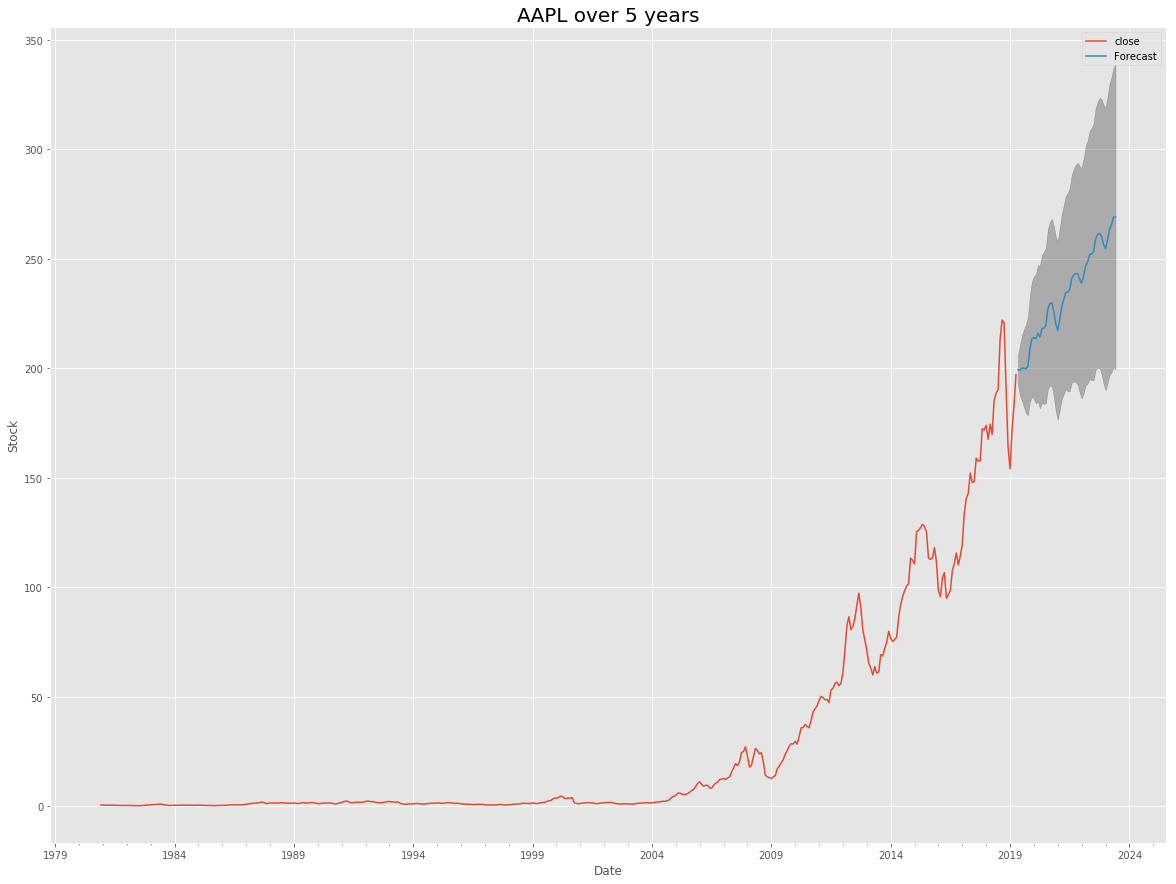

In [72]:
get_prediction('AAPL')

#### Facebook Prophet

In [75]:
def get_prophet(stock):
    model = proph(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)

    stock = get_stock(stock)
    stock = pd.DataFrame(stock['close'])
    stock = pd.DataFrame(stock.resample('MS').mean())
    # rename index column to 'ds' and 'close' column to 'y'
    stock.rename(columns={'close':'y'}, inplace=True)
    stock.index.names = ['ds']
    stock.reset_index(inplace=True)

    model.fit(stock)

    future_dates = model.make_future_dataframe(periods=48, freq='MS')

    forecast = model.predict(future_dates)

    model.plot(forecast, uncertainty=True)
    plt.show();
    
    model.plot_components(forecast);

File already exists...


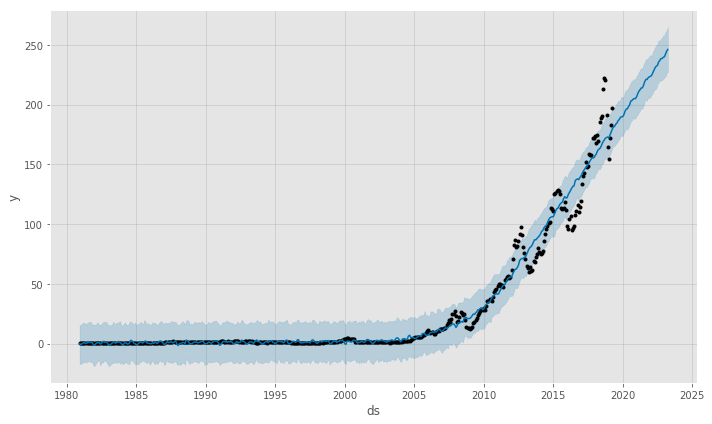

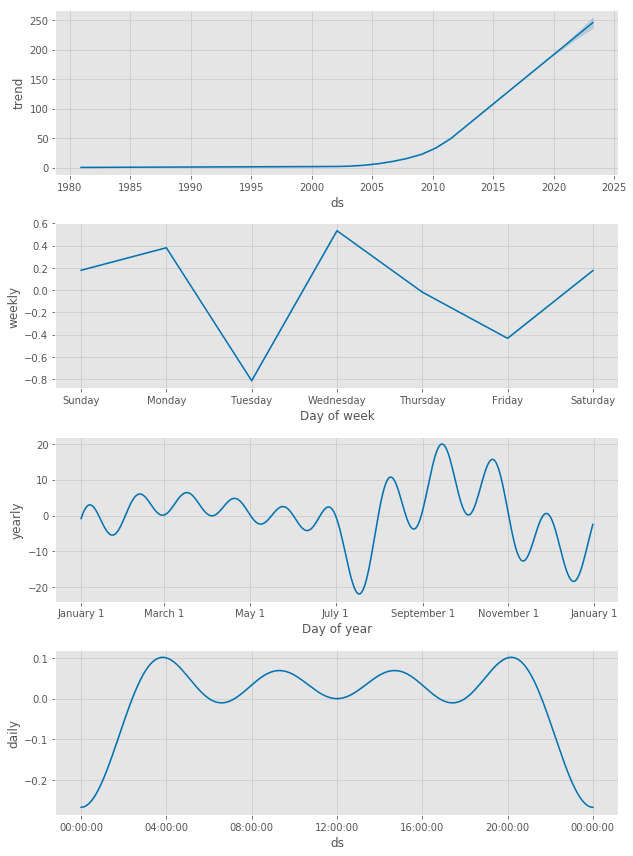

In [76]:
get_prophet('AAPL')